# Titanic Dataset

The aim of this project is to predict if a person onboard the titanic would survive based on predictors given by the titanic dataset. The only goal is to achieve the highest possible prediction accuracy.

This notebook shows the process used to develop an accurate predictor. Much of this code is repeated in an attempt to allow code blocks to be run seperately.

In [1]:
### Load libraries
import pandas as pd
import numpy as np
from pandas.tools.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import Imputer
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import re

In [2]:
######################## Pre-Processing #####################################

#### Coarse pre-Processing

#### Retrieve Dataset

dataset = pd.read_csv('C:/Users/Programming/Desktop/train.csv')

# Check the distribution of Classes
print('Percentage survived:', dataset.Survived[dataset.Survived == 1].count()/dataset.Survived.count())
# 38% of the data results are survivors. This is a relatively good class split ratio and so accuracy can be used as a measure

display(dataset.head(5))

# PassengerId is just sequential numbering and so supplies no information so it can be dropped
dataset.drop(['PassengerId'], axis = 1, inplace = True)

#Passenger name gives little information so drop
dataset.drop(['Name'], axis = 1, inplace = True)

#Ticket may present information but is non-numeric and difficult to transform so I will drop it for the spot check
dataset.drop(['Ticket'], axis = 1, inplace = True)

#### Deal with missing Data

#Calculate percentage of missing data for each column
print('\n Percentage of missing entries for each predictor in Original Dataset\n')
print((dataset.isnull().sum()/len(dataset))*100)

# Cabin number is not present for the majority of passengers so it will be dropped
dataset.drop(['Cabin'], axis = 1, inplace = True)

# A very small number of Embarked data is is missing so these rows can be removed withought losing much data
dataset = dataset[pd.notnull(dataset['Embarked'])]

# Age is missing some values. As most are there and age will most likely be an important factor in survival,
# I will replace the NaNs with the average age
# Imputer from scikit-learn will do this for me
dataset[['Age']] = Imputer().fit_transform(dataset[['Age']].values)

#Sex is non numeric, as there are only 2 classes we can swap male and female for 0 and 1
dataset[['Sex']] = dataset[['Sex']].replace('male', 0)
dataset[['Sex']] = dataset[['Sex']].replace('female', 1)

# use integer encoding for embarked
le = preprocessing.LabelEncoder()
dataset['Embarked'] = le.fit_transform(dataset['Embarked'])

print('\n Percentage of missing entries for each predictor in dataset after processing\n')
print((dataset.isnull().sum()/len(dataset))*100)

print('\nData set sample after coarse preprocessing')
display(dataset.head(5))

# Normalise Column values

def normaliseColumnValues(dataset, columns_to_normalise):
    
    scaler = preprocessing.MinMaxScaler()
    
    for column in columns_to_normalise:
        dataset[column] = scaler.fit_transform(dataset[column].values.reshape(-1, 1))
      
    return dataset

dataset = normaliseColumnValues(dataset, ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'])

print('Data set sample after Normalising')
display(dataset.head(5))


Percentage survived: 0.383838383838


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S



 Percentage of missing entries for each predictor in Original Dataset

Survived     0.000000
Pclass       0.000000
Sex          0.000000
Age         19.865320
SibSp        0.000000
Parch        0.000000
Fare         0.000000
Cabin       77.104377
Embarked     0.224467
dtype: float64

 Percentage of missing entries for each predictor in dataset after processing

Survived    0.0
Pclass      0.0
Sex         0.0
Age         0.0
SibSp       0.0
Parch       0.0
Fare        0.0
Embarked    0.0
dtype: float64

Data set sample after coarse preprocessing


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22.0,1,0,7.2500,2
1,1,1,1,38.0,1,0,71.2833,0
2,1,3,1,26.0,0,0,7.9250,2
3,1,1,1,35.0,1,0,53.1000,2
4,0,3,0,35.0,0,0,8.0500,2


Data set sample after Normalising


C:\Users\Programming\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,1.0,0.0,0.271174,0.125,0.0,0.014151,1.0
1,1,0.0,1.0,0.472229,0.125,0.0,0.139136,0.0
2,1,1.0,1.0,0.321438,0.000,0.0,0.015469,1.0
3,1,0.0,1.0,0.434531,0.125,0.0,0.103644,1.0
4,0,1.0,0.0,0.434531,0.000,0.0,0.015713,1.0


### Summery of course Pre-Processing:

    Distribution of classes: 38%
    
    Missing Data:
    Cabin varible was missing in 77% of examples and so was dropped
    Embarked varible was missing in 0.2% of examples, these examples were dropped
    Age variable was missing in 20% of examples, Interpolation was used to replace missing values with the average age
    
    Non-numeroic Data:
    Sex was integer encoded, 0 for male, 1 for female
    Integer encoding used for embarked
    
    

## Spot check

A spot check is performed to get an idea of which algorithms will work best with this dataset. This will not decide the final algorithm used but is useful in finding which algorithms to start testing on and gives a baseline for prediction accuracy. As the dataset is quite small, calculation time is not a factor and so the spot check will concentrate on accuracy.

A corse run of pre-processing is performed to allow the dataset to be used in the spot check.

In [3]:
#### Testing Parameters

validation_size = 0.20
#Random seed for algorithms is kept constant to make results comparable
seed = 2
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('SVM', SVC()))
models.append(('NB', GaussianNB()))

model_names = ['LR', 'LDA', 'KNN', 'CART', 'NB', 'SVM']

In [4]:
# Useful functions

## Split Predictors and target

def splitPredictorTarget(dataset, target_name):
    
    X = dataset.loc[:, dataset.columns != target_name]
    Y = dataset[['Survived']].dropna()
    
    return X, Y;

from sklearn import model_selection

## Algorithm Spot Check
# Performs K-fold cross validation for each ML model
def spotCheck(X, Y, models, val_size, seed):

    X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, test_size=val_size, random_state=seed)

    # evaluate each model in turn
    results = []
    result_means = []
    resultStd = []
    names = []
    
    print('\nCross Validation with verification set\n')
    
    for name, model in models:
        kfold = model_selection.KFold(n_splits=10, random_state=seed)
        cv_results = model_selection.cross_val_score(model, X_train, Y_train.values.ravel(), cv=kfold, scoring='accuracy')
        results.append(cv_results)
        result_means.append(cv_results.mean())
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        
    print('\n')
    
    #inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    
    return results, result_means;

#Plot the amount each models accuracy has improved from an original data set
def plotModelImprovement(processed_dataset, target, models, validation_size, seed, original_result_means, title):
    
    displayTitle = title.replace('_', ' ')
    
    [X,Y] = splitPredictorTarget(dataset, target)

    [results, result_means] = spotCheck(X, Y, models, validation_size, seed)

    improvement = (np.asarray(result_means) - np.asarray( original_result_means))*100

    improvement_ds = pd.DataFrame(columns = [['improvement']], index = model_names, data = improvement)
    improvement_ds.plot.bar(legend = False, title = displayTitle, ylim = [-5, 5])
    
    plt.savefig(title)
    return

# function to find the percentage of people who survived against a given variable then plot
def findPercentageSurvived(variable, dataset, class_order, plot):
    survived_percentages = []
    classes = dataset[variable].unique()

    for var in classes:
        survival_split = dataset.Survived[dataset[variable] == var].value_counts()

        if survival_split.size == 1:
            survived_percentages.append(survival_split.keys()[0]*100)
        else:
            survived_percentages.append((survival_split[1]/(survival_split[0]+survival_split[1]))*100)

    data = np.array(survived_percentages).T
    variable_survived = pd.DataFrame(data = data, index = classes, columns = ['% Survived'])
    
    if class_order != None:
        variable_survived = variable_survived.reindex(class_order)
    else:
        variable_survived = variable_survived.sort_values(by='% Survived')
    
    if plot == True:
        variable_survived.plot(kind='bar', title = 'Percentage Survived by Passenger ' + variable,legend=False,  figsize=(15, 5))
        plt.savefig('Percentage_Survived_by_Passenger_' + variable)
    return variable_survived

In [5]:
#Perform spot check

[X,Y] = splitPredictorTarget(dataset, 'Survived')
[coarse_results, coarse_result_means] = spotCheck(X, Y, models,  validation_size, seed)


Cross Validation with verification set

LR: 0.791686 (0.057233)
LDA: 0.795892 (0.062976)
KNN: 0.786072 (0.063803)
CART: 0.789045 (0.033803)
SVM: 0.781866 (0.052348)
NB: 0.795931 (0.047961)




LR and LDA produce the best results and provide a basline accuracy of approximately 80%.
Collinear variable warnings are produced due to the one hot encoding method as these variables will be directly correlated.

# Detailed Pre-Processing

The data will now be processed in far more detail. The number of variables in this dataset is small so detailed analysis will be performed on each one in turn.
Using pandas and scikit-learn it is fairly easy to determine a correlation using correlation functions and plots, however, this project will also produce a more easily interpretable percentage survived plot to help understanding. Hopefully, this will also allow other patterns to be spotted in the data as well.

In [6]:
# Reload Dataset
dataset = pd.read_csv('C:/Users/Programming/Desktop/train.csv')

## Passenger Class

Passenger class was likely to determin the location of passengers cabins. Those placed closer to the deck would have a higher chance of survival and so this variable should be correlated with survival.

Correlation between Percentage Survived and Pclass:  [[-0.33848104]]


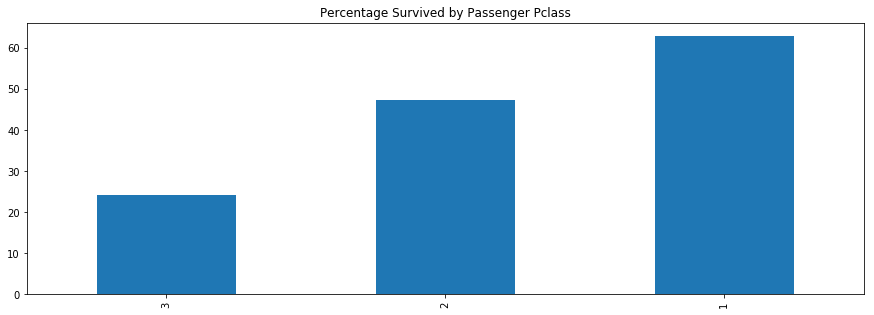

In [7]:
# Visualise Correlation
findPercentageSurvived('Pclass', dataset, None, True);

# Confirm that Pclass has a correlation with survival
print('Correlation between Percentage Survived and Pclass: ' , dataset.corr().loc[['Pclass'], ['Survived']].values)



This shows a significant correlation between survival and Passenger class

## Passenger Name

passengers names themselves are unlikely to be a good predictor and would be difficult to encode, however, passengers titles may provide usefull information.

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Mlle              2
Major             2
Ms                1
Capt              1
the Countess      1
Lady              1
Don               1
Sir               1
Jonkheer          1
Mme               1
Name: Title, dtype: int64


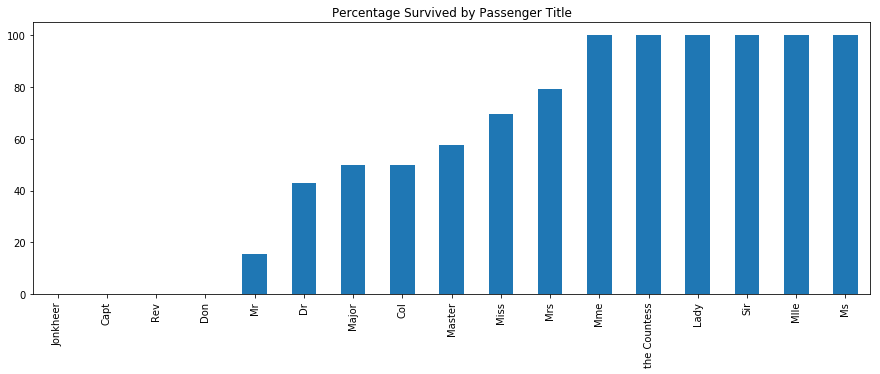

In [8]:
# Reload Dataset
dataset = pd.read_csv('C:/Users/Programming/Desktop/train.csv')

# Replace Name predictor with Titles
dataset['Name'] = dataset['Name'].map(lambda x: x.split(',')[1].split('.')[0].strip())
dataset=dataset.rename(columns = {'two':'new_name'})
dataset = dataset.rename(columns = {'Name':'Title'})

# Visualise Correlation
findPercentageSurvived('Title', dataset, None, True);

# Unbalenced values could cause problems
print(dataset.Title.value_counts())



,Survived,Pclass,Title,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,11,0,22.0,1,0,7.2500,2
1,1,1,12,1,38.0,1,0,71.2833,0
2,1,3,8,1,26.0,0,0,7.9250,2
3,1,1,12,1,35.0,1,0,53.1000,2
4,0,3,11,0,35.0,0,0,8.0500,2


C:\Users\Programming\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)



Cross Validation with verification set

LR: 0.794523 (0.055608)
LDA: 0.794503 (0.059737)
KNN: 0.795951 (0.054164)
CART: 0.777739 (0.038914)
SVM: 0.786072 (0.055845)
NB: 0.784722 (0.046593)




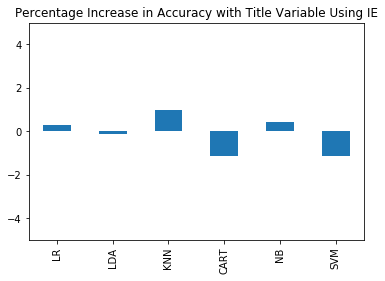

In [9]:
# spot check
# Perform course pre processing but keep title column
dataset.drop(['PassengerId'], axis = 1, inplace = True)
dataset.drop(['Ticket'], axis = 1, inplace = True)
#### Deal with missing Data
dataset.drop(['Cabin'], axis = 1, inplace = True)
dataset = dataset[pd.notnull(dataset['Embarked'])]
dataset[['Age']] = Imputer().fit_transform(dataset[['Age']].values)
dataset[['Sex']] = dataset[['Sex']].replace('male', 0)
dataset[['Sex']] = dataset[['Sex']].replace('female', 1)

# use integer encoding for embarked
le = preprocessing.LabelEncoder()
dataset['Embarked'] = le.fit_transform(dataset['Embarked'])

# Copy dataset for later testing
title_dataset = dataset.copy()

# use integer encoding for Title
le = preprocessing.LabelEncoder()
dataset['Title'] = le.fit_transform(dataset['Title'])

display(dataset.head(5))

# Normalise Data
dataset = normaliseColumnValues(dataset, ['Title', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'])

plotModelImprovement(dataset, 'Survived', models, validation_size, seed, coarse_result_means, 'Percentage_Increase_in_Accuracy_with_Title_Variable_Using_IE')

Try rearanging integer encoding so that the magnitude of encoding has a relatively linear relationship with survival chance:

,Survived,Pclass,Title,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,0,22.0,1,0,7.2500,2
1,1,1,6,1,38.0,1,0,71.2833,0
2,1,3,5,1,26.0,0,0,7.9250,2
3,1,1,6,1,35.0,1,0,53.1000,2
4,0,3,1,0,35.0,0,0,8.0500,2


C:\Users\Programming\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)



Cross Validation with verification set

LR: 0.815591 (0.055635)
LDA: 0.829675 (0.057019)
KNN: 0.800137 (0.059257)
CART: 0.787539 (0.052732)
SVM: 0.793095 (0.054840)
NB: 0.802934 (0.056222)




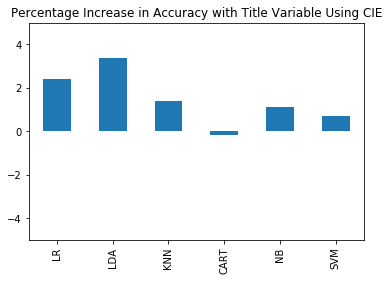

In [10]:

dataset = title_dataset.copy()

replacement = {
    'Don': 0,
    'Rev': 0,
    'Jonkheer': 0,
    'Capt': 0,
    'Mr': 1,
    'Dr': 2,
    'Col': 3,
    'Major': 3,
    'Master': 4,
    'Miss': 5,
    'Mrs': 6,
    'Mme': 7,
    'Ms': 7,
    'Mlle': 7,
    'Sir': 7,
    'Lady': 7,
    'the Countess': 7
}

dataset['Title'] = dataset['Title'].apply(lambda x: replacement.get(x))

display(dataset.head(5))

dataset = normaliseColumnValues(dataset, ['Title', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'])

plotModelImprovement(dataset, 'Survived', models, validation_size, seed, coarse_result_means, 'Percentage_Increase_in_Accuracy_with_Title_Variable_Using_CIE')

Try encoding using one-hot encoding which will allow algorithms to use each title as a separqate variable

C:\Users\Programming\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Programming\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)



Cross Validation with verification set

LR: 0.825450 (0.058655)


C:\Users\Programming\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Programming\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Programming\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Programming\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Programming\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Programming\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are

LDA: 0.831064 (0.064986)
KNN: 0.804382 (0.056728)
CART: 0.791784 (0.046406)
SVM: 0.784644 (0.059376)
NB: 0.611737 (0.147914)




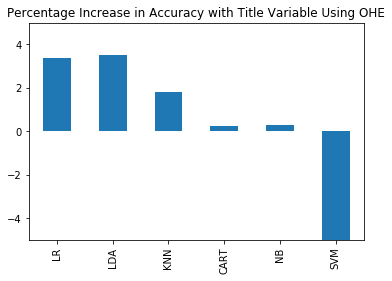

In [11]:
dataset = title_dataset.copy()

one_hot = pd.get_dummies(dataset['Title'])
dataset.drop(['Title'], axis = 1, inplace = True)
dataset = dataset.join(one_hot)

all_titles_to_normalise = np.append(one_hot.columns.values, ['Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Pclass'])

dataset = normaliseColumnValues(dataset, all_titles_to_normalise)

plotModelImprovement(dataset, 'Survived', models, validation_size, seed, coarse_result_means, 'Percentage_Increase_in_Accuracy_with_Title_Variable_Using_OHE')

## Passenger Gender

Women and children were allowed onto lifeboats first and so sex should provide information on survival rate

   Sex
0    1
1    0
2    0
3    0
4    1
5    1
6    1 

Correlation between Percentage Survived and Sex:  [[-0.54335138]]


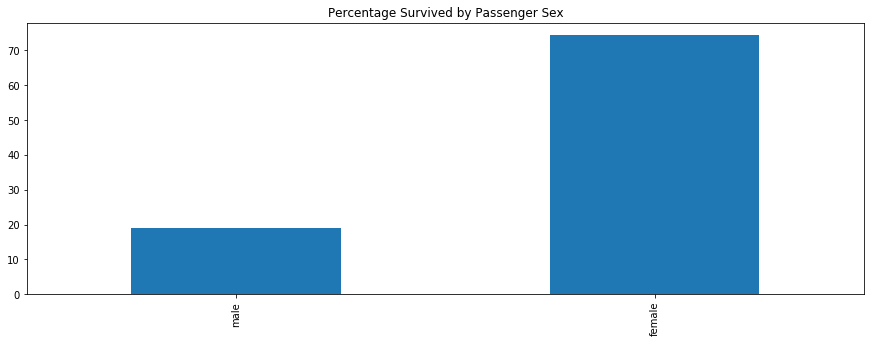

In [12]:
# Reload Dataset
dataset = pd.read_csv('C:/Users/Programming/Desktop/train.csv')

# Visualise Correlation
findPercentageSurvived('Sex', dataset, None, True);

#Sex is non numeric, as there are only 2 classes we can swap male and female for 0 and 1. 
le = preprocessing.LabelEncoder()
dataset['Sex'] = le.fit_transform(dataset['Sex'])

print(dataset[['Sex']].head(7), '\n')

# Confirm that Pclass has a correlation with survival
print('Correlation between Percentage Survived and Sex: ' , dataset.corr().loc[['Sex'], ['Survived']].values)

This shows a very significant correlation between survival and Passenger Title

## Passenger Age

Women and children were allowed onto lifeboats first and so age should provide information on survival rate


Cross Validation with verification set

LR: 0.795912 (0.052315)
LDA: 0.791686 (0.054390)
KNN: 0.748181 (0.060440)
CART: 0.779206 (0.039721)
SVM: 0.748122 (0.062813)
NB: 0.793114 (0.048709)




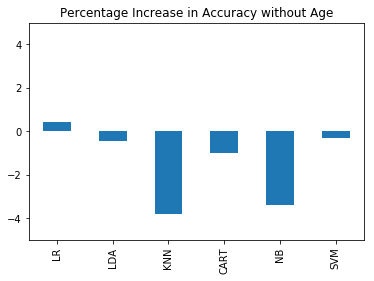

In [13]:
# Reload Dataset
dataset = pd.read_csv('C:/Users/Programming/Desktop/train.csv')

# spot check withought Age to see its effect on performance
# Perform course pre processing but keep title column
dataset.drop(['PassengerId', 'Ticket', 'Name','Age'], axis = 1, inplace = True)
#### Deal with missing Data
dataset.drop(['Cabin'], axis = 1, inplace = True)
dataset = dataset[pd.notnull(dataset['Embarked'])]
dataset[['Sex']] = dataset[['Sex']].replace('male', 0)
dataset[['Sex']] = dataset[['Sex']].replace('female', 1)
# use integer encoding for embarked
le = preprocessing.LabelEncoder()
dataset['Embarked'] = le.fit_transform(dataset['Embarked'])

plotModelImprovement(dataset, 'Survived', models, validation_size, seed, coarse_result_means, 'Percentage_Increase_in_Accuracy_without_Age')

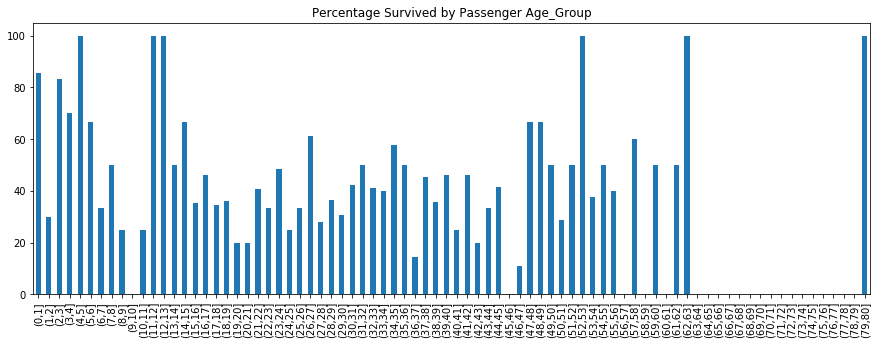

In [14]:
# Reload Dataset
dataset = pd.read_csv('C:/Users/Programming/Desktop/train.csv')

# As above, the missing ages will be replaced by the average age.
dataset[['Age']] = Imputer().fit_transform(dataset[['Age']].values)

# Visualise Correlation
# Group ages to see how grouping effects results
age_bins = []
age_group_names = []
increment = 1;
i = 0
j = 0

while i < 80:
    age_bins.append(i)
    j = i+increment
    age_group_names.append('(' + str(i) + ',' + str(j) + ']')
    i+=increment
    
age_bins.append(i+1)

#age_bins = [0,2,4,6,8,10,12,14,16,18,20,30,40,50,60,70,80]
#age_group_names=['(0,2]', '(2,4]', '(4,6]', '(6,8]', '(8,10]', '(10,12]', '(12,14]', '(14,16]', '(16,18]', '(18,20]', '(20,30]','(30,40]', '(40,50]', '(50,60]', '(60,70]', '(70,80]']
dataset['Age_Group'] = pd.cut(dataset['Age'], age_bins, labels = age_group_names)

percent_survived_data = findPercentageSurvived('Age_Group', dataset, age_group_names, True);




This data would be well correlated to survival despite the odd dip in survival rates of children between 6 and 12. It seems that children between 6 and 12 are less likely to survive than adults.

In [15]:
# Count the nummber of children under 12 for each passenger class

print(dataset['Pclass'][(dataset['Age'] <= 12)].value_counts())

# Show correlation between Pclass and age
print('Correlation between Age and Class: ' , dataset.corr().loc[['Age'], ['Pclass']].values)

3    48
2    17
1     4
Name: Pclass, dtype: int64
Correlation between Age and Class:  [[-0.33133877]]


From this quick analysis it can be seen that the majority of children were in 3rd class which has already been shown to greatly reduce survival chances. It is possible that very young children that could be carried easily were more likely to be taken onto lifeboats ad so had an increased chance of survival, however, older children would have been affected by the same negative factors as adults. This would explain the odd dip insurvival rates and also shows that age may be less of a factor in survival that would be expected.

As using an encoding method that was linearly correlated with survival worked for Titles, I wanted to see how it would effect Age:

C:\Users\Programming\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)



Cross Validation with verification set

LR: 0.822653 (0.045313)
LDA: 0.822633 (0.046598)
KNN: 0.798768 (0.050280)
CART: 0.777719 (0.041457)
SVM: 0.784664 (0.054863)
NB: 0.818447 (0.044552)




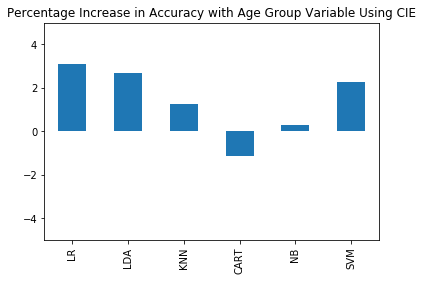

In [16]:

percent_survived_data = percent_survived_data.sort_values(by = '% Survived')
i = 0;
for group in percent_survived_data.index.values:
    dataset.Age_Group = dataset.Age_Group.replace(group, i)
    i+=1

dataset.drop(['Age'], axis = 1, inplace = True)

# spot check
# Perform course pre processing but keep title column
dataset.drop(['PassengerId', 'Ticket', 'Name'], axis = 1, inplace = True)
#### Deal with missing Data
dataset.drop(['Cabin'], axis = 1, inplace = True)
dataset = dataset[pd.notnull(dataset['Embarked'])]
dataset[['Sex']] = dataset[['Sex']].replace('male', 0)
dataset[['Sex']] = dataset[['Sex']].replace('female', 1)
# use integer encoding for embarked
le = preprocessing.LabelEncoder()
dataset['Embarked'] = le.fit_transform(dataset['Embarked'])

#save to test one-hot after
age_group_dataset = dataset.copy()

dataset = normaliseColumnValues(dataset, ['Pclass', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Age_Group'])

plotModelImprovement(dataset, 'Survived', models, validation_size, seed, coarse_result_means, 'Percentage_Increase_in_Accuracy_with_Age_Group_Variable_Using_CIE')

Interestingly this does generally increase the accuracy of the model. If the bin increments are decresed to 1 year, the largest gain in accuracy is seen. This is expected as in this case no information is lost i the grouping process. It seems that ordering the data helps algorithms to model the data. I would assume this is a similar effect to standardising normally distributed data.

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,0,1,2,...,60,61,62,63,64,65,66,67,68,69
0,0,3,0,1,0,7.2500,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,0,71.2833,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,3,1,0,0,7.9250,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,0,53.1000,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,3,0,0,0,8.0500,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0


C:\Users\Programming\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)



Cross Validation with verification set

LR: 0.822653 (0.045313)
LDA: 0.822633 (0.046598)
KNN: 0.798768 (0.050280)
CART: 0.779167 (0.052403)
SVM: 0.784664 (0.054863)
NB: 0.818447 (0.044552)




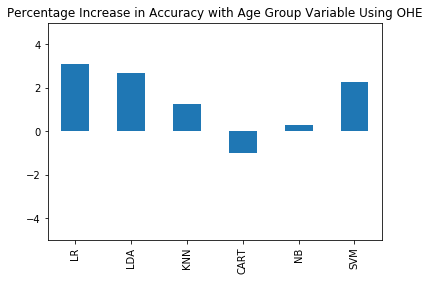

In [17]:
#Try one hot encoding Age_Group

one_hot = pd.get_dummies(age_group_dataset['Age_Group'])
age_group_dataset.drop(['Age_Group'], axis = 1, inplace = True)
age_group_dataset = age_group_dataset.join(one_hot)

display(age_group_dataset.head(5))

all_titles_to_normalise =  ['SibSp', 'Parch', 'Fare', 'Embarked', 'Pclass']

age_group_dataset = normaliseColumnValues(age_group_dataset, all_titles_to_normalise)

plotModelImprovement(age_group_dataset, 'Survived', models, validation_size, seed, coarse_result_means, 'Percentage_Increase_in_Accuracy_with_Age_Group_Variable_Using_OHE')

## Number of Siblings/Spouces

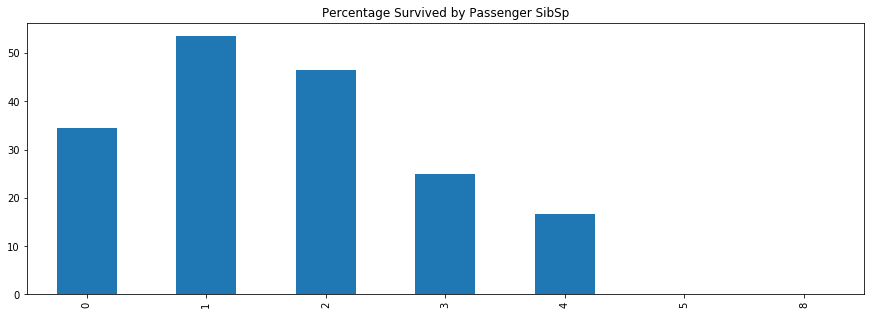

In [18]:
# Reload Dataset
dataset = pd.read_csv('C:/Users/Programming/Desktop/train.csv')

percent_survived_data = findPercentageSurvived('SibSp', dataset, [0,1,2,3,4,5,8], True);

Try correclated integer encoding

C:\Users\Programming\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)



Cross Validation with verification set

LR: 0.795912 (0.055979)
LDA: 0.787461 (0.059836)
KNN: 0.786131 (0.050174)
CART: 0.791862 (0.024843)
SVM: 0.781866 (0.052348)
NB: 0.773474 (0.068174)




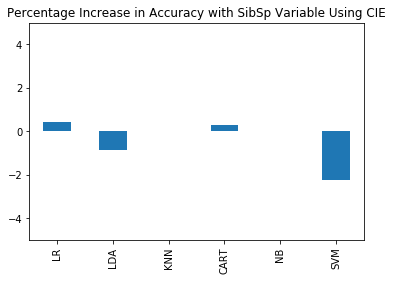

In [19]:
# Try Correlated Integer Encoding

dataset = pd.read_csv('C:/Users/Programming/Desktop/train.csv')

percent_survived_data = percent_survived_data.sort_values(by = '% Survived')
i = 0;
for group in percent_survived_data.index.values:
    dataset.SibSp = dataset.SibSp.replace(group, i)
    i+=1

# spot check
# Perform course pre processing but keep title column
dataset.drop(['PassengerId', 'Ticket', 'Name'], axis = 1, inplace = True)
#### Deal with missing Data
dataset.drop(['Cabin'], axis = 1, inplace = True)
dataset = dataset[pd.notnull(dataset['Embarked'])]
dataset[['Age']] = Imputer().fit_transform(dataset[['Age']].values)
# use integer encoding for embarked
le = preprocessing.LabelEncoder()
dataset['Embarked'] = le.fit_transform(dataset['Embarked'])
dataset[['Sex']] = dataset[['Sex']].replace('male', 0)
dataset[['Sex']] = dataset[['Sex']].replace('female', 1)

dataset = normaliseColumnValues(dataset, ['Pclass', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Age'])

plotModelImprovement(dataset, 'Survived', models, validation_size, seed, coarse_result_means, 'Percentage_Increase_in_Accuracy_with_SibSp_Variable_Using_CIE')

C:\Users\Programming\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Programming\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Programming\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Programming\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Programming\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Programming\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Varia


Cross Validation with verification set

LR: 0.805732 (0.052099)
LDA: 0.805732 (0.053229)
KNN: 0.772085 (0.053221)
CART: 0.789006 (0.027608)
SVM: 0.784664 (0.051890)
NB: 0.424746 (0.044779)




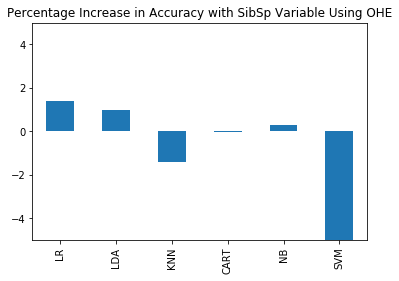

In [20]:
# Try One Hot Encoding

dataset = pd.read_csv('C:/Users/Programming/Desktop/train.csv')

one_hot = pd.get_dummies(dataset['SibSp'])
dataset.drop(['SibSp'], axis = 1, inplace = True)
dataset = dataset.join(one_hot)

# spot check
# Perform course pre processing but keep title column
dataset.drop(['PassengerId', 'Ticket', 'Name'], axis = 1, inplace = True)
#### Deal with missing Data
dataset.drop(['Cabin'], axis = 1, inplace = True)
dataset = dataset[pd.notnull(dataset['Embarked'])]
dataset[['Age']] = Imputer().fit_transform(dataset[['Age']].values)
# use integer encoding for embarked
le = preprocessing.LabelEncoder()
dataset['Embarked'] = le.fit_transform(dataset['Embarked'])
dataset[['Sex']] = dataset[['Sex']].replace('male', 0)
dataset[['Sex']] = dataset[['Sex']].replace('female', 1)

dataset = normaliseColumnValues(dataset, ['Pclass', 'Parch', 'Fare', 'Embarked', 'Age'])

plotModelImprovement(dataset, 'Survived', models, validation_size, seed, coarse_result_means, 'Percentage_Increase_in_Accuracy_with_SibSp_Variable_Using_OHE')

## Parent/Child

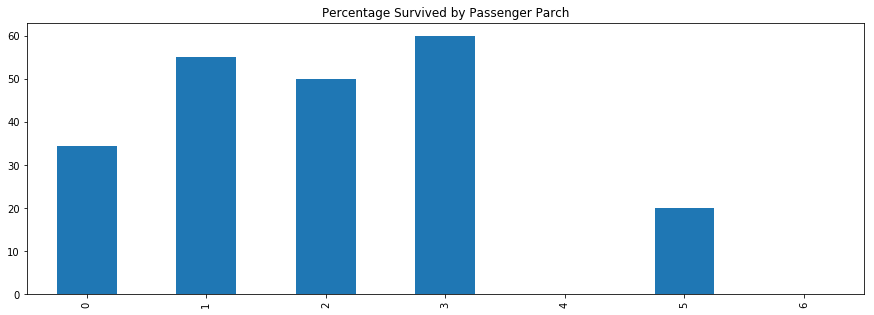

In [21]:
# Reload Dataset
dataset = pd.read_csv('C:/Users/Programming/Desktop/train.csv')

percent_survived_data = findPercentageSurvived('Parch', dataset, [0,1,2,3,4,5,6], True);

C:\Users\Programming\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)



Cross Validation with verification set

LR: 0.788889 (0.053366)
LDA: 0.794484 (0.062647)
KNN: 0.783275 (0.059425)
CART: 0.786228 (0.039660)
SVM: 0.784664 (0.054863)
NB: 0.786072 (0.055845)




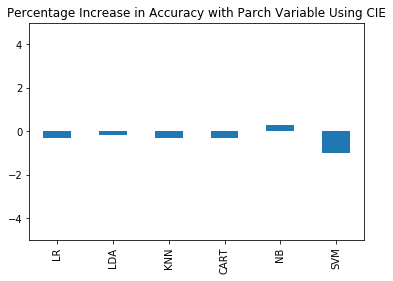

In [22]:
dataset = pd.read_csv('C:/Users/Programming/Desktop/train.csv')

percent_survived_data = percent_survived_data.sort_values(by = '% Survived')
i = 0;
for group in percent_survived_data.index.values:
    dataset.Parch = dataset.Parch.replace(group, i)
    i+=1

# spot check
# Perform course pre processing but keep title column
dataset.drop(['PassengerId', 'Ticket', 'Name'], axis = 1, inplace = True)
#### Deal with missing Data
dataset.drop(['Cabin'], axis = 1, inplace = True)
dataset = dataset[pd.notnull(dataset['Embarked'])]
dataset[['Age']] = Imputer().fit_transform(dataset[['Age']].values)
# use integer encoding for embarked
le = preprocessing.LabelEncoder()
dataset['Embarked'] = le.fit_transform(dataset['Embarked'])
dataset[['Sex']] = dataset[['Sex']].replace('male', 0)
dataset[['Sex']] = dataset[['Sex']].replace('female', 1)

dataset = normaliseColumnValues(dataset, ['Pclass', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Age'])

plotModelImprovement(dataset, 'Survived', models, validation_size, seed, coarse_result_means, 'Percentage_Increase_in_Accuracy_with_Parch_Variable_Using_CIE')

C:\Users\Programming\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Programming\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Programming\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Programming\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Programming\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Programming\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Varia


Cross Validation with verification set

LR: 0.794503 (0.055965)
LDA: 0.793095 (0.058685)
KNN: 0.777680 (0.056529)
CART: 0.777778 (0.034944)
SVM: 0.781866 (0.052348)
NB: 0.405067 (0.056265)




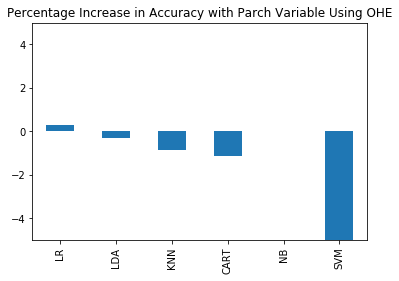

In [23]:
dataset = pd.read_csv('C:/Users/Programming/Desktop/train.csv')

one_hot = pd.get_dummies(dataset['Parch'])
dataset.drop(['Parch'], axis = 1, inplace = True)
dataset = dataset.join(one_hot)

# spot check
# Perform course pre processing but keep title column
dataset.drop(['PassengerId', 'Ticket', 'Name'], axis = 1, inplace = True)
#### Deal with missing Data
dataset.drop(['Cabin'], axis = 1, inplace = True)
dataset = dataset[pd.notnull(dataset['Embarked'])]
dataset[['Age']] = Imputer().fit_transform(dataset[['Age']].values)
# use integer encoding for embarked
le = preprocessing.LabelEncoder()
dataset['Embarked'] = le.fit_transform(dataset['Embarked'])
dataset[['Sex']] = dataset[['Sex']].replace('male', 0)
dataset[['Sex']] = dataset[['Sex']].replace('female', 1)

dataset = normaliseColumnValues(dataset, ['Pclass', 'SibSp', 'Fare', 'Embarked', 'Age'])

plotModelImprovement(dataset, 'Survived', models, validation_size, seed, coarse_result_means, 'Percentage_Increase_in_Accuracy_with_Parch_Variable_Using_OHE')

## Ticket
The ticket variable may hold valuable information for predictors, however, in its raw state is is unusable as it is a non-numeric variable with no seperate classes to group into. The ticket values can be split into a Prefix string and a number. The number always starts with the passenger class which provides no new information and there is no obvious information provided my the rest of the number. For this reason we will use the prefixes to see if they provide any new information. Any Tickets that did not have a prefix will be given a placeholder prefix 'U'. The following plot shows the percentage survival rate for each prefix.

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,0,3,0,22.0,1,0,A/5,7.2500,2
1,1,1,1,38.0,1,0,PC,71.2833,0
2,1,3,1,26.0,0,0,STON/O2.,7.9250,2
3,1,1,1,35.0,1,0,U,53.1000,2
4,0,3,0,35.0,0,0,U,8.0500,2


C:\Users\Programming\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)



Cross Validation with verification set

LR: 0.793095 (0.059690)
LDA: 0.795912 (0.057724)
KNN: 0.795912 (0.062983)
CART: 0.793290 (0.033050)
SVM: 0.781866 (0.052348)
NB: 0.795951 (0.042695)




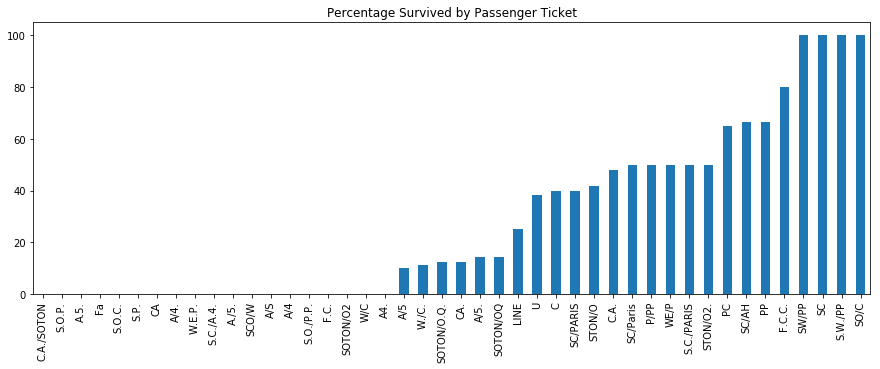

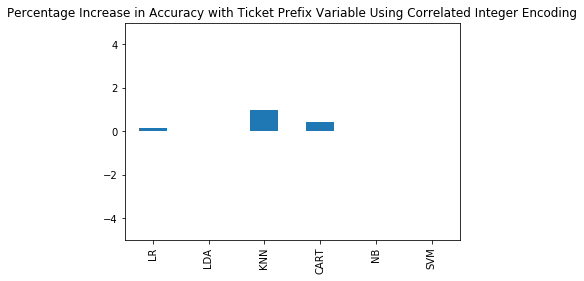

In [24]:
# Reload Dataset
dataset = pd.read_csv('C:/Users/Programming/Desktop/train.csv')

# transform Ticket to only contain the ticket Prefix
def getTicketPrefix(x):
    if re.search('[a-zA-Z]', x):
        if ' ' in x:
            [x,_] = x.split(' ',1)
            return x
        else:
            return x
    x = 'U'
    return x
dataset.Ticket = dataset.Ticket.apply(getTicketPrefix)

percent_survived_data = findPercentageSurvived('Ticket', dataset, None, True);

dataset.drop(['PassengerId'], axis = 1, inplace = True)
dataset.drop(['Name'], axis = 1, inplace = True)
#dataset.drop(['Ticket'], axis = 1, inplace = True)
dataset.drop(['Cabin'], axis = 1, inplace = True)
dataset = dataset[pd.notnull(dataset['Embarked'])]
dataset[['Age']] = Imputer().fit_transform(dataset[['Age']].values)
dataset[['Sex']] = dataset[['Sex']].replace('male', 0)
dataset[['Sex']] = dataset[['Sex']].replace('female', 1)
# use integer encoding for embarked
le = preprocessing.LabelEncoder()
dataset.Embarked = le.fit_transform(dataset.Embarked)

# Make copy to perform one-hot Encoding on
one_hot_dataset = dataset.copy()

display(dataset.head(5))

percent_survived_data = percent_survived_data.sort_values(by = '% Survived')
i = 0;
for group in percent_survived_data.index.values:
    dataset.Ticket = dataset.Ticket.replace(group, i)
    i+=1

dataset.Ticket = le.fit_transform(dataset.Ticket)

dataset = normaliseColumnValues(dataset, ['Pclass', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Age', 'Ticket'])
    
plotModelImprovement(dataset, 'Survived', models, validation_size, seed, coarse_result_means, 'Percentage Increase in Accuracy with Ticket Prefix Variable Using Correlated Integer Encoding')

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,A./5.,A.5.,...,SOTON/O2,SOTON/OQ,STON/O,STON/O2.,SW/PP,U,W./C.,W.E.P.,W/C,WE/P
0,0,3,0,22.0,1,0,7.2500,2,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,38.0,1,0,71.2833,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,3,1,26.0,0,0,7.9250,2,0,0,...,0,0,0,1,0,0,0,0,0,0
3,1,1,1,35.0,1,0,53.1000,2,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,3,0,35.0,0,0,8.0500,2,0,0,...,0,0,0,0,0,1,0,0,0,0


C:\Users\Programming\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)



Cross Validation with verification set

LR: 0.793095 (0.059690)
LDA: 0.795912 (0.057724)
KNN: 0.795912 (0.062983)
CART: 0.794679 (0.034449)
SVM: 0.781866 (0.052348)
NB: 0.795951 (0.042695)




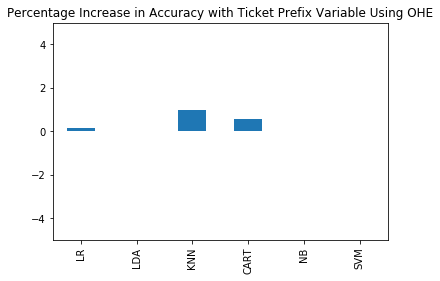

In [25]:
#Try one hot encoding Prefix

one_hot = pd.get_dummies(one_hot_dataset['Ticket'])
one_hot_dataset.drop(['Ticket'], axis = 1, inplace = True)
one_hot_dataset = one_hot_dataset.join(one_hot)

display(one_hot_dataset.head(5))

all_titles_to_normalise =  ['Pclass', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Age']

one_hot_dataset = normaliseColumnValues(one_hot_dataset, all_titles_to_normalise)

plotModelImprovement(one_hot_dataset, 'Survived', models, validation_size, seed, coarse_result_means, 'Percentage_Increase_in_Accuracy_with_Ticket_Prefix_Variable_Using_OHE')



## Combine

In [26]:
dataset = pd.read_csv('C:/Users/Programming/Desktop/train.csv')

In [27]:
# Remove Passenger Id and Cabin Id
dataset.drop(['PassengerId'], axis = 1, inplace = True)
dataset.drop(['Cabin'], axis = 1, inplace = True)
dataset.drop(['Ticket'], axis = 1, inplace = True)

In [28]:
# Impute Missing ages
dataset[['Age']] = Imputer().fit_transform(dataset[['Age']].values)

In [29]:
# A very small number of Embarked data is is missing so these rows can be removed withought losing much data
dataset = dataset[pd.notnull(dataset['Embarked'])]

In [30]:
#Sex is non numeric, as there are only 2 classes we can swap male and female for 0 and 1
dataset[['Sex']] = dataset[['Sex']].replace('male', 0)
dataset[['Sex']] = dataset[['Sex']].replace('female', 1)

#Get ticket prefixes
#ticket_ds = pd.DataFrame(columns = [['Prefix']], data = dataset.Ticket.values.copy())

def getTicketPrefix(x):
    if re.search('[a-zA-Z]', x):
        if ' ' in x:
            [x,_] = x.split(' ',1)
            return x
        else:
            return x
    x = 'U'
    return x

dataset['Prefix'] = dataset.Ticket.apply(getTicketPrefix)
#dataset = dataset.join(dataset.Survived)

#Integer encode Prefixes in an order correlated with Survival
percent_survived_data = findPercentageSurvived('Prefix', dataset, None, False);
percent_survived_data = percent_survived_data.sort_values(by = '% Survived')
i = 0;
for group in percent_survived_data.index.values:
    dataset.Prefix = dataset.Prefix.replace(group, i)
    i+=1

dataset.drop(['Ticket'], axis = 1, inplace = True)

In [31]:
# Replace Name with Titles
dataset['Name'] = dataset['Name'].map(lambda x: x.split(',')[1].split('.')[0].strip())
dataset= dataset.rename(columns = {'two':'new_name'})
dataset = dataset.rename(columns = {'Name':'Title'})

replacement = {
    'Don': 0,
    'Rev': 0,
    'Jonkheer': 0,
    'Capt': 0,
    'Mr': 1,
    'Dr': 2,
    'Col': 3,
    'Major': 3,
    'Master': 4,
    'Miss': 5,
    'Mrs': 6,
    'Mme': 7,
    'Ms': 7,
    'Mlle': 7,
    'Sir': 7,
    'Lady': 7,
    'the Countess': 7
}

dataset['Title'] = dataset['Title'].apply(lambda x: replacement.get(x))

display(dataset.head(5))



,Survived,Pclass,Title,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,0,22.0,1,0,7.2500,S
1,1,1,6,1,38.0,1,0,71.2833,C
2,1,3,5,1,26.0,0,0,7.9250,S
3,1,1,6,1,35.0,1,0,53.1000,S
4,0,3,1,0,35.0,0,0,8.0500,S


In [32]:
# use integer encoding for embarked
le = preprocessing.LabelEncoder()
dataset.Embarked = le.fit_transform(dataset.Embarked)


In [33]:
# Put ages into bins
age_bins = []
age_group_names = []
increment = 1;
i = 0
j = 0

while i < 80:
    age_bins.append(i)
    j = i+increment
    age_group_names.append('(' + str(i) + ',' + str(j) + ']')
    i+=increment
    
age_bins.append(i+1)

dataset['Age_Group'] = pd.cut(dataset['Age'], age_bins, labels = age_group_names)
percent_survived_data = findPercentageSurvived('Age_Group', dataset, age_group_names, False);

percent_survived_data = percent_survived_data.sort_values(by = '% Survived')
i = 0;
for group in percent_survived_data.index.values:
    dataset.Age_Group = dataset.Age_Group.replace(group, i)
    i+=1

dataset.drop(['Age'], axis = 1, inplace = True)

In [34]:
#normalise data
dataset = normaliseColumnValues(dataset, ['Pclass', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Age_Group'])

display(dataset.head(5))

C:\Users\Programming\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


,Survived,Pclass,Title,Sex,SibSp,Parch,Fare,Embarked,Age_Group
0,0,1.0,1,0,0.125,0.0,0.014151,1.0,0.550725
1,1,0.0,6,1,0.125,0.0,0.139136,0.0,0.521739
2,1,1.0,5,1,0.000,0.0,0.015469,1.0,0.391304
3,1,0.0,6,1,0.125,0.0,0.103644,1.0,0.782609
4,0,1.0,1,0,0.000,0.0,0.015713,1.0,0.782609


In [35]:
#Perform spot check
[X,Y] = splitPredictorTarget(dataset, 'Survived')
[results, result_means] = spotCheck(X, Y, models,  validation_size, seed)


Cross Validation with verification set

LR: 0.836718 (0.052193)
LDA: 0.831084 (0.057553)
KNN: 0.807218 (0.039660)
CART: 0.804441 (0.035016)
SVM: 0.819836 (0.059212)
NB: 0.814182 (0.055762)





Cross Validation with verification set

LR: 0.836718 (0.052193)
LDA: 0.831084 (0.057553)
KNN: 0.807218 (0.039660)
CART: 0.798807 (0.034823)
SVM: 0.819836 (0.059212)
NB: 0.814182 (0.055762)




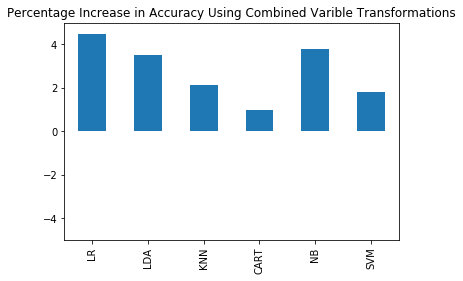

In [36]:
plotModelImprovement(dataset, 'Survived', models, validation_size, seed, coarse_result_means, 'Percentage_Increase_in_Accuracy_Using_Combined_Varible_Transformations')